# Simple Gaussian Model with BBVI

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Generate data from a simple model: Normal(10, 1)
data = np.random.normal(loc = 10, scale = 1, size = 100)

C:\Users\inigo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\inigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Manual estimation of the gradient of the ELBO

In [2]:
# Gradient estimator using sampling -- vanilla BBVI
# We here assume the model X ~ Normal(mu, 1)
# with unknown mu, that in itself is Normal, mean 0 and standard deviation 1000, 
# so effectively an uniformed prior. 
# The variational dstribution for mu is also Normal, with parameter q_mu_lambda
# -- taking the role of lambda in the calculations -- and variance 1.

def grad_estimate(q_mu_lambda, samples = 1):
    # sum_grad_estimate will hold the sum as we move along over the <samples> samples. 
    sum_grad_estimate = 0
    for i in range(samples):
        # Sample one example from current best guess for the variational distribution
        mu_sample = np.random.normal(loc=q_mu_lambda, scale=1, size=1)
        
        # Now we want to calculate the contribution from this sample, namely 
        # [log p(x, mu_sample) - log q(mu|lambda) ] * grad( log q(mu_sample|lambda) )
        #
        # First log p(x|mu_sample) + log p(mu_sample) - log q(mu_sample|lambda) 
        value = np.sum(norm.logpdf(data, loc=mu_sample, scale=1)) 
        + norm.logpdf(mu_sample, loc = 0, scale = 1000)  
        - norm.logpdf(mu_sample, loc= q_mu_lambda, scale = 1)
        
        # Next grad (log q(mu_sample|lambda))
        # The Normal distribution gives the score function with known variance as <value> - <mean>
        grad_q = mu_sample - q_mu_lambda
        
        # grad ELBO for this sample is therefore in total given by
        sum_grad_estimate = sum_grad_estimate + grad_q * value
        
    # Divide by number of samples to get average value -- the estimated expectation  
    return sum_grad_estimate/samples

# Checking the variation in gradient estimate

M =  1 sample(s) in BBVI -- Mean of gradient: 152.317; Std.dev. of gradient: 446.189
M =  2 sample(s) in BBVI -- Mean of gradient: 114.013; Std.dev. of gradient: 276.508
M =  3 sample(s) in BBVI -- Mean of gradient: 110.025; Std.dev. of gradient: 229.800
M =  4 sample(s) in BBVI -- Mean of gradient: 109.298; Std.dev. of gradient: 207.534
M =  5 sample(s) in BBVI -- Mean of gradient: 120.882; Std.dev. of gradient: 182.995
M = 10 sample(s) in BBVI -- Mean of gradient: 109.816; Std.dev. of gradient: 129.777
M = 25 sample(s) in BBVI -- Mean of gradient: 110.765; Std.dev. of gradient:  84.450


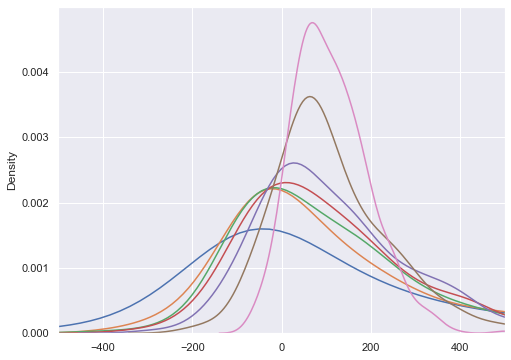

In [13]:
# To check the variation / "unreliability" of the gradient estimate we repeat 
# several times for the same lambda value and notice difference

# Location to check -- close to the data mean (at +10). 
# The prior will move the variational optimium **slightly** away from the data mean, 
# but due to the large prior variance of mu this should be a very limited effect.
# We should therefore expect a positive derivative (since we want to move 
# q_mu_lambda towards the data mean, that is, **increase** it)
q_mu_lambda = 9

plt.figure(figsize=(8,6))
sns.set()
# Do with different sample sizes
for sample_count in [1, 2, 3, 4, 5, 10, 25]:

    #loop
    q_grad = []
    for t in range(500):
        q_grad.append(grad_estimate(q_mu_lambda, samples=sample_count))

    sns.distplot(q_grad, hist=False, label="$M = {:d}$".format(sample_count))
    
    # Report back
    print("M = {:2d} sample(s) in BBVI -- Mean of gradient: {:7.3f}; Std.dev. of gradient: {:7.3f}".format(
        sample_count, np.mean(q_grad), np.std(q_grad)))

plt.xlim([-500, 500])
plt.show()      



## Exercise

* What can we say about the gradient estimate based on the plots above?
* Implement and test your own gradient ascent learning algorithm starting from, say, q_mu_lambda=-10. Experiment with different learning rates, number of samples used for the gradient estimate, possibly supplemented with momentum.
* Optional: Adapt the implementation above so that we can also learn the variance of the q distribution 

What can we say about the gradient estimate based on the plots above?

We can see that the higher the number of samples, the more specific the distribution becomes. For samples = 1 we can see we are very unsure about the distribution of the samples as seen by the big standard deviation as opposed to the more thin ones such as samples = 25.

### EXPLANATION:

So what we do here is we plot 500 different points.

All these points are (in this case) 1 dimensional points that guide us towards what LAMBDA we should choose in order to pick the right q (a normal distribution) that we're going to be fitting onto p (the original distribution)

From all these points we get the normal distribution that describes them and that's where we see that for higher number of samples we get a more specific distribution, since we're obtaining e.g 25 points and we're computing the mean of all of them.

Note that we're obtaining derivatives so that if we start at x = 9, we want to reach x = 10 (because mean of p is 10) so the gradients will point in the direction towards 10 (although they might point in the wrong direction too, reason why we use multiple samples)



In [16]:
def gradient_ascent(q_mu_lambda):
    learning_rate =.001
    for i in range(400):
        q_mu_lambda = q_mu_lambda + learning_rate * grad_estimate(q_mu_lambda, samples = 1)
        print(q_mu_lambda)

In [17]:
gradient_ascent(q_mu_lambda)

[9.96314309]
[9.94775756]
[10.53527225]
[10.8276903]
[10.70662077]
[10.1533996]
[9.6786808]
[9.58225028]
[10.59851366]
[10.48293214]
[10.54292409]
[10.71888084]
[9.42424376]
[9.36819511]
[9.32153796]
[9.82847148]
[10.03958375]
[10.13683588]
[10.38585546]
[10.59504476]
[10.67078285]
[10.89395471]
[11.490827]
[11.63788151]
[11.50818885]
[11.83202901]
[12.02095471]
[11.75422495]
[11.68755233]
[11.76293695]
[11.93959621]
[11.44289709]
[11.58927415]
[11.76567828]
[11.94406813]
[11.78683059]
[11.33897121]
[11.52716275]
[10.54541526]
[10.56918852]
[10.73680188]
[10.8185674]
[10.82324283]
[11.00034233]
[10.57500848]
[10.62302546]
[11.6323768]
[11.58379701]
[11.50158403]
[11.64759123]
[11.85251663]
[11.90570253]
[11.42433349]
[11.60069261]
[11.72878378]
[11.75648894]
[11.60027672]
[11.67253225]
[11.44005292]
[11.66382086]
[11.6073904]
[11.78509922]
[12.22100854]
[9.96455083]
[9.97097736]
[9.83457062]
[9.96665206]
[10.12714074]
[10.2071426]
[9.94796924]
[9.75460967]
[9.46434212]
[8.72328089]
[8.